# CPSC 330 Lecture 13

### Lecture plan

- 👋
- **Turn on recording**
- Announcements
- Multi-class classification (15 min)
- Intro to computer vision (5 min)
- Intro to neural networks (15 min)
- Break (5 min)
- Neural networks for images (15 min)
- Pre-trained networks (15 min)
- Transfer learning (15 min)

In [1]:
import pandas as pd
import numpy as np

import os 

import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn import datasets

In [2]:
plt.rcParams['font.size'] = 16

In [12]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras import utils
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions

## Announcements

- Midterm grading in progress
- hw6 will be posted at the end of this week hopefully

## Multi-class classification (15 min)


- I intended to cover this at some point but it didn't really come up naturally.
- We briefly talked about it in Lecture 14 on neural networks & computer vision.
- Most of the classification problems we looked at were binary classification (2 possible labels)
- There are plenty of multi-class classification problems as well.

In [190]:
data = sklearn.datasets.load_wine()
X = pd.DataFrame(data['data'], columns=data["feature_names"])
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [191]:
X_train

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
109,11.61,1.35,2.70,20.0,94.0,2.74,2.92,0.29,2.49,2.65,0.960,3.26,680.0
106,12.25,1.73,2.12,19.0,80.0,1.65,2.03,0.37,1.63,3.40,1.000,3.17,510.0
134,12.51,1.24,2.25,17.5,85.0,2.00,0.58,0.60,1.25,5.45,0.750,1.51,650.0
89,12.08,1.33,2.30,23.6,70.0,2.20,1.59,0.42,1.38,1.74,1.070,3.21,625.0
12,13.75,1.73,2.41,16.0,89.0,2.60,2.76,0.29,1.81,5.60,1.150,2.90,1320.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
51,13.83,1.65,2.60,17.2,94.0,2.45,2.99,0.22,2.29,5.60,1.240,3.37,1265.0
62,13.67,1.25,1.92,18.0,94.0,2.10,1.79,0.32,0.73,3.80,1.230,2.46,630.0
70,12.29,1.61,2.21,20.4,103.0,1.10,1.02,0.37,1.46,3.05,0.906,1.82,870.0
71,13.86,1.51,2.67,25.0,86.0,2.95,2.86,0.21,1.87,3.38,1.360,3.16,410.0


In [192]:
y_train

array([1, 1, 2, 1, 0, 2, 1, 1, 0, 0, 2, 1, 1, 1, 0, 0, 0, 2, 2, 2, 1, 2,
       0, 2, 2, 1, 0, 2, 1, 0, 1, 2, 0, 2, 0, 2, 1, 1, 2, 0, 2, 2, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 2, 2, 1, 2, 1, 2, 0, 0, 1, 1, 2, 2, 1, 0, 1,
       1, 0, 2, 0, 2, 1, 0, 1, 1, 1, 2, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       2, 2, 0, 2, 1, 1, 2, 1, 2, 2, 0, 0, 0, 2, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 2, 0, 2, 1, 1, 0, 1, 1, 2, 1, 1, 1, 2, 1, 0, 1, 1, 1,
       0])

- Note that we have 3 classes here: 0, 1, 2.
- For some models, like a random forest, we don't have to think about anything differently at all:

In [193]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train);

In [194]:
rf.predict(X_test)

array([0, 0, 0, 1, 2, 1, 2, 0, 0, 0, 1, 1, 2, 0, 1, 1, 1, 0, 2, 2, 1, 0,
       0, 2, 1, 1, 0, 1, 1, 2, 2, 1, 2, 0, 1, 2, 0, 2, 1, 1, 1, 0, 1, 2,
       1])

In [195]:
rf_importances = pd.DataFrame(data=rf.feature_importances_, index=X_train.columns, columns=["Importance"])
rf_importances.sort_values(by="Importance")

,Importance
ash,0.011616
nonflavanoid_phenols,0.012012
proanthocyanins,0.012043
alcalinity_of_ash,0.016882
magnesium,0.029298
malic_acid,0.045506
total_phenols,0.045682
hue,0.083974
color_intensity,0.107607
od280/od315_of_diluted_wines,0.119953


- Everything is the same here.
- For our linear classifier, on the other hand, things are a bit different:

In [196]:
lr = LogisticRegression(max_iter=10000)
lr.fit(X_train, y_train);

In [197]:
lr.predict(X_test)

array([0, 0, 0, 1, 2, 1, 2, 0, 0, 0, 1, 1, 2, 0, 1, 1, 1, 0, 2, 2, 1, 0,
       0, 2, 1, 1, 0, 1, 1, 2, 2, 1, 2, 0, 1, 2, 0, 2, 1, 1, 1, 0, 1, 2,
       1])

In [204]:
lr.predict_proba(X_test)[:10]

array([[9.83121095e-01, 1.30404370e-02, 3.83846763e-03],
       [9.95736967e-01, 1.69179383e-03, 2.57123874e-03],
       [9.99913071e-01, 4.17255306e-06, 8.27563492e-05],
       [2.21058877e-03, 9.97237440e-01, 5.51971365e-04],
       [1.55535649e-03, 1.51962649e-03, 9.96925017e-01],
       [1.40295571e-04, 9.99655016e-01, 2.04688647e-04],
       [1.77145916e-03, 1.22119079e-02, 9.86016633e-01],
       [9.99998530e-01, 1.01172179e-10, 1.46997299e-06],
       [9.99957179e-01, 1.40043113e-05, 2.88168294e-05],
       [9.96393323e-01, 2.52352829e-04, 3.35432433e-03]])

In [205]:
np.argmax(lr.predict_proba(X_test), axis=1)

array([0, 0, 0, 1, 2, 1, 2, 0, 0, 0, 1, 1, 2, 0, 1, 1, 1, 0, 2, 2, 1, 0,
       0, 2, 1, 1, 0, 1, 1, 2, 2, 1, 2, 0, 1, 2, 0, 2, 1, 1, 1, 0, 1, 2,
       1])

In [206]:
lr.predict(X_test)

array([0, 0, 0, 1, 2, 1, 2, 0, 0, 0, 1, 1, 2, 0, 1, 1, 1, 0, 2, 2, 1, 0,
       0, 2, 1, 1, 0, 1, 1, 2, 2, 1, 2, 0, 1, 2, 0, 2, 1, 1, 1, 0, 1, 2,
       1])

In [198]:
lr_coefs = pd.DataFrame(data=lr.coef_, index=X_train.columns, columns=["Coefficient"])
lr_coefs.sort_values(by="Coefficient")

ValueError: Shape of passed values is (3, 13), indices imply (13, 1)

What is going on here?

In [199]:
lr.coef_.shape

(3, 13)

What's happening here is that we have one coefficient per feature _per class_. 

In [200]:
lr_coefs = pd.DataFrame(data=lr.coef_.T, index=X_train.columns, columns=lr.classes_)
lr_coefs

,0,1,2
alcohol,0.660312,-0.691072,0.030761
malic_acid,0.540192,-0.791026,0.250834
ash,0.708200,-0.874055,0.165855
alcalinity_of_ash,-0.211434,0.122472,0.088962
magnesium,-0.019100,-0.016223,0.035323
total_phenols,0.247848,0.154682,-0.402530
flavanoids,0.804320,0.425621,-1.229941
nonflavanoid_phenols,0.087637,0.024024,-0.111661
proanthocyanins,0.076671,0.395400,-0.472071
color_intensity,0.186333,-0.948383,0.762051


In [202]:
# lr_coefs.sum(axis=1)

The interpretation is a feature importance for predicting a certain class. For example:

In [ ]:
lr_coefs.loc["alcohol", 2]

- Means that if alcohol is larger, you are more likely to predict class 2. 
- The specific interpretation depends on the way the logistic regression is implementing multi-class.

In [208]:
# ?LogisticRegression

- We can see that there's a `multi_class` parameter, that can be set to `'ovr'` or `'multinomial'`, or you can have it automatically choose between the two, which is the default.
  - In CPSC 340 we discuss in detail the difference between these two approaches.
  - In CPSC 340 we make an argument for preferring `'multinomial'`, but in short it doesn't matter which one you choose.
- If you want a general feature importance irrespective of class, you could try looking for features where the coefficients have large absolute values.

In [211]:
# lr_multi = LogisticRegression(max_iter=10000, multi_class='multinomial')
# lr_multi.fit(X_train, y_train);

In [212]:
# lr_multi_coefs = pd.DataFrame(data=lr_multi.coef_.T, index=X_train.columns, columns=lr.classes_)
# lr_multi_coefs

Note that the output of `predict_proba` now contains a probability for each class:

In [213]:
lr.predict_proba(X_test)[:5]

array([[9.83121095e-01, 1.30404370e-02, 3.83846763e-03],
       [9.95736967e-01, 1.69179383e-03, 2.57123874e-03],
       [9.99913071e-01, 4.17255306e-06, 8.27563492e-05],
       [2.21058877e-03, 9.97237440e-01, 5.51971365e-04],
       [1.55535649e-03, 1.51962649e-03, 9.96925017e-01]])

And you'll see that each row adds up to 1, as expected:

In [214]:
np.sum(lr.predict_proba(X_test), axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

We can still make a confusion matrix:

In [215]:
confusion_matrix(y_test, lr.predict(X_test))

array([[14,  0,  0],
       [ 0, 19,  0],
       [ 0,  0, 12]])

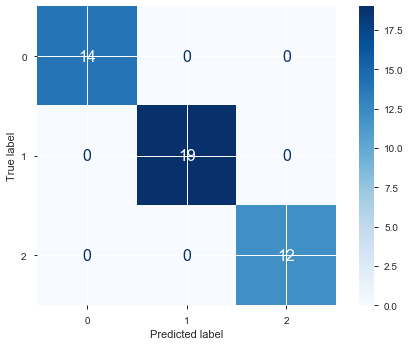

In [216]:
plot_confusion_matrix(lr, X_test, y_test, display_labels=lr.classes_, cmap=plt.cm.Blues, values_format = 'd');

- Precision, recall, etc. don't apply directly.
- But if we pick one of the classes as positive, and consider the rest to be negative, then we can.

In [217]:
print(classification_report(y_test, lr.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      1.00      1.00        19
           2       1.00      1.00      1.00        12

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45



- We can also make the plots we made earlier in the course, but this time with more classes.
- I need to train a model with only 2 features for this to work:

In [218]:
lr_2f = LogisticRegression()
lr_2f.fit(X_train.iloc[:,:2], y_train);

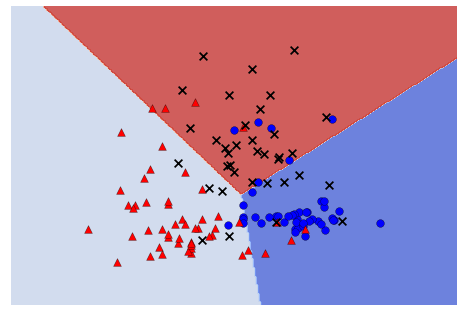

In [219]:
plot_classifier(X_train.iloc[:,:2], y_train, lr_2f);

Note: the colours aren't very good - the red triangles correspond to the light blue predictions, the black X's correspond to the red predictions, and the blue circles (correctly) correspond to the blue circles.

We can do the same with a random forest:

In [220]:
rf_2f = RandomForestClassifier()
rf_2f.fit(X_train.iloc[:,:2], y_train);

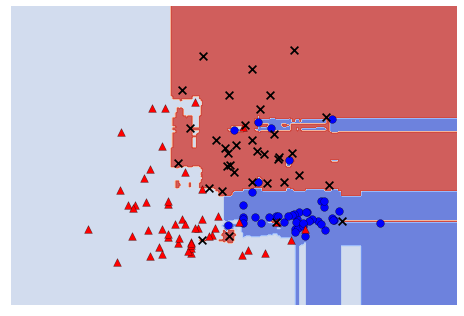

In [221]:
plot_classifier(X_train.iloc[:,:2], y_train, rf_2f);

Or an RBF SVM:

In [222]:
svm_2f = SVC(kernel="rbf", gamma=2, C=100)
svm_2f.fit(X_train.iloc[:,:2], y_train);

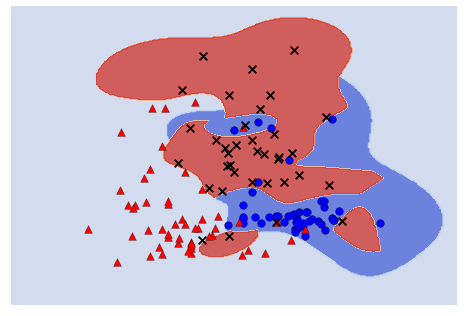

In [223]:
plot_classifier(X_train.iloc[:,:2], y_train, svm_2f);

## Intro to computer vision (5 min)

- [Computer vision](https://en.wikipedia.org/wiki/Computer_vision) refers to understanding images/videos, usually using ML/AI. 
- Like NLP, computer vision has many tasks of interest:
  - image classification: is this a cat or a dog?
  - object localization: where are the people in this image?
  - image segmentation: what are the various parts of this image?
  - motion detection: what moved between frames of a video?
  - and much more...
- We will focus on image classification.

## The ImageNet dataset (5min)

## Intro to neural networks (15 min)

- Remember the `Pipeline`? 
- A neural network is a model that's sort of like its own pipeline.
  - It involves a series of transformations ("layers") internally. 
  - The output is the prediction.
- The code looks like this:

In [4]:
model = Sequential()
model.add(Dense(10, input_dim=1, activation='tanh'))
model.add(Dense(15, activation='tanh'))
model.add(Dense(1, activation='linear'))

- Each time we do `model.add` we are adding on one of those transformations.
- Imporant question: how many features before/after transformation.
  - e.g. scaling doesn't change the number of features
  - OHE increases the number of features
- With a neural net, you specify the number of features after each transformation.
  - In the above, it goes from 1 to 10 to 15 to 1.

Note: in scikit-learn, we use one line of Python code to set up the model and set the hyperparameters. For example:


In [5]:
lr = LogisticRegression(C=5)

- In tensorflow.keras (the package we're using), we use multiple lines of Python code to set up the model.
- This design decision just makes the code more human-readable.
- One line of code per layer of the network.
- But there's nothing fundamental about it, one could also put the architecture/hypers on one line, in a file, etc.

- Next, with tensorflow, we have an extra step not present in sklearn, called `compile`.
- Let's ignore this for now.

In [6]:
model.compile(loss='mean_squared_error', optimizer="adam")

Let's try it out on some made up data:

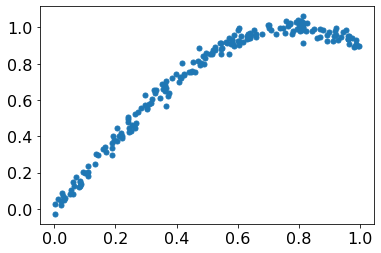

In [7]:
np.random.seed(5)
N = 200
X = np.random.rand(N,1)
y = np.sin(2*X) + np.random.randn(N,1)*0.03

plt.plot(X,y,'.',markersize=10);

The rest is what we're used to: `fit`, `predict`, etc. 

In [8]:
model.fit(X, y, epochs=1000, verbose=0);

(Note how even fitting such a simple dataset can be slow with neural networks.)

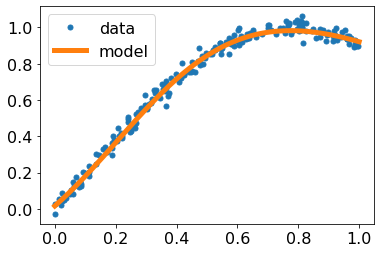

In [9]:
plt.plot(X,y,'.',markersize=10,label="data")
grid = np.linspace(0,1,1000)[:,None]
plt.plot(grid, model.predict(grid),linewidth=5,label="model")
plt.legend();

Instead of `score` we use `evaluate`:

In [10]:
model.evaluate(X, y, verbose=0)

0.0009070498635992408

#### Terminology

- Neural network = neural net
- Deep learning ~ using neural networks

#### Why neural networks?

- They can learn very complex functions.
  - The fundamental tradeoff is primarily controlled by the **number of layers** and **layer sizes**.
  - More layers / bigger layers --> more complex model.
  - You can generally get a model that will not underfit.
- The work really well for structured data:
  - 1D sequence, e.g. timeseries, language
  - 2D image
  - 3D image or video
- They've had some incredible successes in the last 10 years.
- Transfer learning (coming later today) is really useful.

#### Why not neural networks?

- Often they require a lot of data.
- They require a lot of compute time, and, to be faster, specialized hardware called [GPUs](https://en.wikipedia.org/wiki/Graphics_processing_unit).
- They have huge numbers of hyperparameters are a huge pain to tune.
  - Think of each layer having hyperparameters, plus some overall hyperparameters.
  - Being slow compounds this problem.
- They are not interpretable.
- When you call `fit`, you are not guaranteed to get the optimal.
  - There are now a bunch of hyperparameters specific to `fit`, rather than the model.
  - You never really know if `fit` was successful or not.
  - You never really know if you should have run `fit` for longer.
- I don't recommend training them without further training (ha)
  - Take CPSC 340 and other courses if you're interested.
  - I'll show you some ways to use neural networks without calling `fit`.

#### Deep learning software

- scikit-learn has [MLPRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html) and [MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) but they aren't very flexible.
  - In general you'll want to leave the scikit-learn ecosystem when using neural networks.
  - Fun fact: these classes were contributed to scikit-learn by a UBC graduate student.
- There's been a lot of deep learning software out there.
- The current big players are:

1. [TensorFlow 2.0](https://www.tensorflow.org)
2. [PyTorch](http://pytorch.org)

- Both are heavily used in industry.
- A lot of people I talk to say PyTorch is easier to use.
  - However, I started teaching this in MDS 4 years ago, before PyTorch was created!
- If interested, see [comparison of deep learning software](https://en.wikipedia.org/wiki/Comparison_of_deep_learning_software).

## Neural networks for images (10 min)

- Let's load the MNIST handwritten digits dataset.
- It's a very boring dataset by now - we can get extremely high accuracy, and we've probably overfit to the test set by now.
- But it's a good example to see.

In [14]:
# the data, shuffled and split between train and test sets
(X_train_img, y_train), (X_test_img, y_test) = mnist.load_data()

In [15]:
X_train_img.shape

(60000, 28, 28)

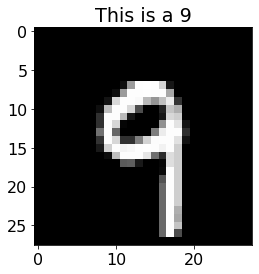

In [16]:
# display a random training example
i = np.random.randint(0,len(X_train_img))
plt.imshow(X_train_img[i],cmap='gray')
plt.title('This is a %d' % y_train[i]);

In [17]:
type(X_train_img[i])

numpy.ndarray

In [18]:
X_train_img[i].shape

(28, 28)

In [19]:
X_train_img.shape

(60000, 28, 28)

- How can we take our input ($28\times 28$ numpy array) and map it out our output (a label $0,1,\ldots,9$)?
- Most naive approach: "flatten" the images, and then use whatever supervised learning method we feel like.

In [20]:
X_train = X_train_img.reshape(60000, 28*28)
X_test = X_test_img.reshape(10000, 28*28)
X_train = X_train / 255 # this is the same a min/max scaling, since the pixel intensities range from 0 to 255
X_test = X_test / 255

print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

60000 train samples
10000 test samples


In [21]:
X_train.shape

(60000, 784)

In [22]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

Note: I secretly introduced multi-class classification here.

# TODO -add a bit more on this

Now we can use our usual classification methods:

In [23]:
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs')

Note: setting `multi_class="multinomial"` because we have more than 2 classes.

In [24]:
lr.fit(X_train, y_train);

/opt/miniconda3/envs/cpsc330env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [25]:
lr.score(X_train, y_train)

0.93505

In [26]:
lr.score(X_test, y_test)

0.9258

In [27]:
z = np.array([[1,2],[3,4]])

In [28]:
z

array([[1, 2],
       [3, 4]])

In [29]:
z.shape

(2, 2)

In [30]:
np.reshape(z, (4,))

array([1, 2, 3, 4])

- Why is this a bad idea?
  - By "flattening" the image we throw away useful information.
- What the computer sees:

In [31]:
list(X_train[0])[150:200]

[0.0,
 0.0,
 0.011764705882352941,
 0.07058823529411765,
 0.07058823529411765,
 0.07058823529411765,
 0.49411764705882355,
 0.5333333333333333,
 0.6862745098039216,
 0.10196078431372549,
 0.6509803921568628,
 1.0,
 0.9686274509803922,
 0.4980392156862745,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.11764705882352941,
 0.1411764705882353,
 0.3686274509803922,
 0.6039215686274509,
 0.6666666666666666,
 0.9921568627450981,
 0.9921568627450981,
 0.9921568627450981,
 0.9921568627450981,
 0.9921568627450981,
 0.8823529411764706,
 0.6745098039215687,
 0.9921568627450981,
 0.9490196078431372,
 0.7647058823529411,
 0.25098039215686274,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

- Hard to classify this!
- [Convolutional neural networks](https://en.wikipedia.org/wiki/Convolutional_neural_network) (CNNs) can take in images without flattening them.
  - We won't cover CNNs here, but they are in CPSC 340.

## Break (5 min)

## Using pre-trained networks (15 min)

- `tf.keras` has a bunch of pre-trained computer vision models available, see [here](https://keras.io/applications/).
- Here we load a pre-trained model (uses our internet connection).
- The amazing part is how much effort went into this base model. 
  - An insane amount of labelled data.
  - An insane amount of compute time.
  - An insane amount of human effort tuning the model.

In [ ]:
resnet = ResNet50(weights='imagenet')

Note the important distinction between the choice of architecture (in this case, `ResNet50`) and the choice of dataset (in this case, ImageNet).

# TODO: introduce imageNet

Here's my graduation photo from undergrad:

In [ ]:
img_path = 'data/gelbart-michael-adam.jpg'
img = load_img(img_path, target_size=(224, 224))
plt.imshow(img);

In [ ]:
x = img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = resnet.predict(x)
decode_predictions(preds, top=3)[0]

In [ ]:
img_path = 'data/office.jpg'
img = load_img(img_path, target_size=(224, 224))
plt.imshow(img);

In [ ]:
x = img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = resnet.predict(x)
decode_predictions(preds, top=3)[0]

- We got these predictions without "doing the ML ourselves".
- Can be useful for cases like sentiment analysis.
- In fact, that is what we did last class with the word-embeddings! 
  - And, it was indeed also a deep learning model that was used there.

## Transfer learning (15 min)

- Let's look at the [Kaggle dog breed identification](https://www.kaggle.com/c/dog-breed-identification/data) dataset. 
- But let's imagine we only have 2000 examples, to simulate only having a small dataset available to us.

In [ ]:
data = pd.read_csv('data/dog-breed-identification/labels.csv')
data = data[:2000]
data['image_path'] = data.apply( lambda row: (os.path.join("data/dog-breed-identification/train", row["id"] + ".jpg") ), axis=1)
data.head()

Above: you can see some of the breeds that we're predicting.

In [ ]:
target_labels = data['breed']
total_classes = len(set(target_labels))
print("number of dog breeds:", total_classes)

In [ ]:
# read images from the image directory. 
images = np.array([img_to_array(
                    load_img(img, target_size=(256,256))
                    ) for img in data['image_path'].values.tolist()])

In [ ]:
images.shape

Above: we have 2000 images, each of size $256 \times 256$ and with 3 colour channels.

In [ ]:
images = images.astype('float32')/255.0 

Above: it's very important to scale the images!

In [ ]:
plt.imshow(images[0]);
plt.grid(True);
plt.xticks([]);
plt.yticks([]);
plt.title("Breed = " + target_labels[0]);

Above: this is a sample image from the dog breed data set.

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(images, target_labels, 
                                                    stratify=np.array(target_labels), 
                                                    random_state=42)

In [ ]:
print(X_train.shape)
print(X_valid.shape)

The dataset seems fairly balanced:

In [ ]:
target_labels.value_counts()

Meaning DummyClassifier gets a horrible accuracy:

In [ ]:
dc = DummyClassifier(strategy='prior')
dc.fit(X_train, y_train);

In [ ]:
dc.score(X_train, y_train)

In [ ]:
dc.score(X_valid, y_valid)

We have roughly $1500/120=12.5$ images per class. **This is tiny compared to what we're used to.** What can we do??

- We can use **transfer learning**.
- We'll use a model trained on one task as a starting point for learning to perform another task. 
- Why is transfer learning helpful to us? Why can't we just train a model with the second task's objectives from the beginning? 
  - It's difficult to obtain labeled data: ususally we need a whole lot of data in order to solve complex problems, and it can be hard to collect the data.

In [ ]:
base_inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

- Note the `include_top=False`. 
- This throws away the last layer. 
- It wasn't useful to us anyway. 
- ImageNet has 1000 classes, but we're not interested in those classes. 
- We don't want their predictions; we want every step in their "pipeline" except the predictions.
- We will the feature extractor and then train our own model from the tools we know.

- The next line turns the pre-trained model into something we can use.
- The syntax and details are out of scope here.

In [ ]:
feature_extractor = Model(inputs=base_inception.input, outputs=GlobalAveragePooling2D()(base_inception.output))

The next lines may take a long time:

In [ ]:
%%time
Z_train = feature_extractor.predict(X_train)
Z_valid = feature_extractor.predict(X_valid)

In [ ]:
Z_train.shape

In [ ]:
lr = LogisticRegression(multi_class="multinomial", solver="lbfgs")
lr.fit(Z_train, y_train);

In [ ]:
lr.score(Z_train, y_train)

In [ ]:
lr.score(Z_valid, y_valid)

# TODO- compare with logistic reg on flattened images

- This is an incredible accuracy for so little effort!!!
- I challenge you to get accuracy anywhere near this high with only 2000 examples using other methods, including deep learning!

## Random cool stuff

- Style transfer: given a "content image" and a "style image", create a new image with the content of one and the style of the other.
  - Here is the [original paper from 2015](https://arxiv.org/pdf/1508.06576.pdf), see Figure 2.
  - Here are more in [this 2016 paper](https://arxiv.org/pdf/1601.04589.pdf); see, e.g. Figures 1 and 7.
  - This has been done for video as well; see [this video from 2016](https://www.youtube.com/watch?v=Khuj4ASldmU).
- Colourization: see [this 2016 project](http://iizuka.cs.tsukuba.ac.jp/projects/colorization/en/).
- Inceptionism: let the neural network "make things up"
  - [2015 article](https://ai.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html)
  - "Deep dream" [video from 2015](https://www.youtube.com/watch?v=dbQh1I_uvjo).